In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Version 1

In [32]:
import os
import numpy as np
import pandas as pd

def load_signals(data_dir, split):
    signal_types = [
        'body_acc_x', 'body_acc_y', 'body_acc_z',
        'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
        'total_acc_x', 'total_acc_y', 'total_acc_z'
    ]
    signals = []
    for sig in signal_types:
        file_path = os.path.join(data_dir, split, 'Inertial Signals', f"{sig}_{split}.txt")
        signal = np.loadtxt(file_path)
        signals.append(signal)
    return np.dstack(signals)  # shape: (samples, timesteps, features)

def load_labels(data_dir, split):
    file_path = os.path.join(data_dir, split, f"y_{split}.txt")
    return pd.read_csv(file_path, header=None).values.flatten() - 1  # zero-indexed

def load_uci_har_dataset(data_dir):
    X_train = load_signals(data_dir, 'train')
    y_train = load_labels(data_dir, 'train')
    X_test = load_signals(data_dir, 'test')
    y_test = load_labels(data_dir, 'test')
    return X_train, y_train, X_test, y_test

DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset'
X_train, y_train, X_test, y_test = load_uci_har_dataset(DATA_DIR)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

def split_sequences(data, window_size=128, step=64):
    """
    Split the data into sequences with overlapping windows

    Args:
        data: Input data with shape (n_samples, n_features)
        window_size: Number of time steps in each sequence
        step: Step size between consecutive sequences

    Returns:
        Sequences with shape (n_sequences, window_size, n_features)
    """
    n_samples, n_features = data.shape
    sequences = []

    for i in range(0, n_samples - window_size + 1, step):
        sequence = data[i:i + window_size]
        sequences.append(sequence)

    return np.array(sequences)



# Check the current shape of the data
print(f"Original training data shape: {X_train.shape}")
print(f"Original test data shape: {X_test.shape}")

# The data already has 128 timestamps per sample, so we can use it directly
# If we need to adjust window size or create overlapping windows:
window_size = 128  # This is already the size in the dataset
step = 128  # Non-overlapping by default - set to smaller value for overlap

# Check if we need to reshape the data
if X_train.shape[1] != window_size or step != window_size:
    print("Reshaping data to adjust window size or create overlapping samples...")
    # Flatten the data to 2D and then recreate sequences
    X_train_flat = X_train.reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2])
    X_test_flat = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])

    # Create new sequences
    X_train_seq = split_sequences(X_train_flat, window_size=window_size, step=step)
    X_test_seq = split_sequences(X_test_flat, window_size=window_size, step=step)

    # Create corresponding labels for sequences
    # For each sequence, we'll use the mode of the labels
    orig_samples_per_window = X_train.shape[1] / window_size

    y_train_seq = []
    for i in range(0, len(X_train_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / X_train.shape[1])
        mode_label = y_train[orig_sample_idx]
        y_train_seq.append(mode_label)

    y_test_seq = []
    for i in range(0, len(X_test_flat) - window_size + 1, step):
        # Map back to original sample indices
        orig_sample_idx = int(i / X_test.shape[1])
        mode_label = y_test[orig_sample_idx]
        y_test_seq.append(mode_label)

    y_train_seq = np.array(y_train_seq)
    y_test_seq = np.array(y_test_seq)
else:
    # If no reshaping is needed, use the data directly
    X_train_seq = X_train
    X_test_seq = X_test
    y_train_seq = y_train
    y_test_seq = y_test

# One-hot encode labels
y_train_seq_onehot = tf.keras.utils.to_categorical(y_train_seq, num_classes=6)
y_test_seq_onehot = tf.keras.utils.to_categorical(y_test_seq, num_classes=6)

print(f"Final training data shape: {X_train_seq.shape}")
print(f"Final training labels shape: {y_train_seq_onehot.shape}")
print(f"Final test data shape: {X_test_seq.shape}")
print(f"Final test labels shape: {y_test_seq_onehot.shape}")


Train shape: (7352, 128, 9) (7352,)
Test shape: (2947, 128, 9) (2947,)
Original training data shape: (7352, 128, 9)
Original test data shape: (2947, 128, 9)
Final training data shape: (7352, 128, 9)
Final training labels shape: (7352, 6)
Final test data shape: (2947, 128, 9)
Final test labels shape: (2947, 6)


In [35]:
class MST_Block(layers.Layer):
    def __init__(self, filters, kernel_sizes=(3, 5, 7), **kwargs):
        super(MST_Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes

        # For each kernel size, create a depthwise conv layer
        self.conv_layers = []

        # Follow the paper's guideline for dimension allocation
        if len(kernel_sizes) == 3:  # Stage-1 with 3 kernel sizes
            self.filter_dims = [filters//4, filters//4, filters//2]  # 32, 32, 64 for filters=128
        else:  # Stage-2/3 with 2 kernel sizes
            self.filter_dims = [filters//2, filters//2]  # 각각 64로 설정하여 합이 128이 되도록 수정

        # Create depthwise convolution for each kernel size
        for i, k_size in enumerate(kernel_sizes):
            self.conv_layers.append(
                layers.DepthwiseConv1D(
                    kernel_size=k_size,
                    strides=1,
                    padding='same',
                    depth_multiplier=1,
                    activation=None,
                    name=f'dwconv_{k_size}'
                )
            )

        # Projection layers after each convolution
        self.proj_layers = []
        for i in range(len(kernel_sizes)):
            self.proj_layers.append(
                layers.Conv1D(
                    filters=self.filter_dims[i],
                    kernel_size=1,
                    activation='relu',
                    name=f'proj_{self.kernel_sizes[i]}'
                )
            )

        # Layer normalization
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)

        # Window-based self-attention (W-SA) with relative position bias
        self.attention = layers.MultiHeadAttention(
            num_heads=4,
            key_dim=filters // 4
        )

        # 출력 차원을 명확하게 일치시키기 위한 투영 레이어 추가
        self.output_proj = layers.Conv1D(filters, kernel_size=1, activation=None)

        # MLP after attention
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(filters * 4, activation='relu'),
            layers.Dense(filters)
        ])

    def call(self, inputs):
        # Multi-scale feature aggregation
        x = inputs
        feature_maps = []

        for i, conv_layer in enumerate(self.conv_layers):
            # Apply depthwise convolution
            conv_out = conv_layer(x)
            # Apply projection
            proj_out = self.proj_layers[i](conv_out)
            feature_maps.append(proj_out)

        # Concatenate along feature dimension
        concat_features = tf.concat(feature_maps, axis=-1)

        # 출력 차원을 입력 차원과 정확히 일치시키기 위해 투영
        x = self.output_proj(concat_features)

        # Apply window-based self-attention with relative position bias
        attn_input = self.layer_norm1(x)
        attention_output = self.attention(attn_input, attn_input)
        x = x + attention_output

        # Apply MLP with residual connection
        mlp_input = self.layer_norm2(x)
        mlp_output = self.mlp(mlp_input)
        return x + mlp_output




class PAT_Block(layers.Layer):
    def __init__(self, num_bases=96, **kwargs):
        super(PAT_Block, self).__init__(**kwargs)
        self.num_bases = num_bases

        # Linear layer for query transformation
        self.query_proj = layers.Dense(128, name='query_proj')

        # MLP for base estimation with linear layer and ReLU
        self.base_mlp = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(128)
        ], name='base_mlp')

        # Final MLP for output
        self.final_mlp = tf.keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(128)
        ], name='final_mlp')

    def build(self, input_shape):
        # For simplicity, we'll use fixed bases for all samples in a batch
        # In a complete implementation, this should be dynamic using K-means per sample
        self.bases = self.add_weight(
            name='bases',
            shape=(self.num_bases, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        super(PAT_Block, self).build(input_shape)

    def call(self, inputs):
        # Calculate queries from input
        queries = self.query_proj(inputs)

        # Process bases through the MLP
        processed_bases = self.base_mlp(self.bases)

        # Calculate attention scores between queries and bases
        # Shape: (batch_size, sequence_length, num_bases)
        attention_scores = tf.matmul(queries, tf.transpose(processed_bases))

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # Calculate re-estimated features by weighted sum of bases
        # Shape: (batch_size, sequence_length, feature_dim)
        reestimated = tf.matmul(attention_weights, processed_bases)

        # Calculate feature difference (like PCT paper)
        feature_diff = reestimated - inputs

        # Apply final MLP and residual connection
        output = inputs + self.final_mlp(feature_diff)

        return output




class TCAM(layers.Layer):
    """Temporal Context Attention Module"""
    def __init__(self, filters, num_heads=4, **kwargs):
        super(TCAM, self).__init__(**kwargs)
        self.filters = filters
        self.num_heads = num_heads

        # Temporal position encoding
        self.pos_encoding = self.add_weight(
            name='temporal_pos_encoding',
            shape=(1, 128, filters),  # Assuming max 128 timesteps
            initializer='glorot_uniform',
            trainable=True
        )

        # Temporal attention mechanism
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=filters // num_heads
        )

        # Bidirectional feature enhancement for capturing context
        self.bi_lstm = layers.Bidirectional(
            layers.LSTM(filters // 2, return_sequences=True)
        )

        # Normalization and projection
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.proj = layers.Conv1D(filters, kernel_size=1)

    def call(self, inputs):
        # Apply position encoding
        seq_len = tf.shape(inputs)[1]
        pos_enc = self.pos_encoding[:, :seq_len, :]
        x = inputs + pos_enc

        # Capture temporal context via attention
        attn_input = self.layer_norm1(x)
        attn_output = self.mha(attn_input, attn_input)
        x = x + attn_output

        # Enhance with bidirectional context
        lstm_input = self.layer_norm2(x)
        lstm_output = self.bi_lstm(lstm_input)

        # Integrate features and project
        x = x + lstm_output
        x = self.proj(x)
        return x




class MTSI(layers.Layer):
    """Multi-Temporal Scale Integration Module"""
    def __init__(self, filters, scales=[3, 9, 27], **kwargs):
        super(MTSI, self).__init__(**kwargs)
        self.filters = filters
        self.scales = scales

        # Convolutions for various temporal scales
        self.temp_convs = []
        for scale in scales:
            self.temp_convs.append(layers.Conv1D(
                filters=filters // len(scales),
                kernel_size=scale,
                padding='same',
                dilation_rate=1,
                activation='relu'
            ))

        # Multi-scale feature integration
        self.integration = layers.Conv1D(filters, kernel_size=1)
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Extract features at multiple temporal scales
        multi_scale_features = []
        for conv in self.temp_convs:
            multi_scale_features.append(conv(inputs))

        # Integrate features
        x = layers.Concatenate()(multi_scale_features)
        x = self.integration(x)
        x = self.norm(x)

        # Residual connection
        return x + inputs




class ABFA(layers.Layer):
    """Action-Based Feature Augmentation Module"""
    def __init__(self, filters, activity_classes=6, **kwargs):
        super(ABFA, self).__init__(**kwargs)
        self.filters = filters
        self.activity_classes = activity_classes

        # Action prototypes (feature prototype for each activity class)
        self.action_prototypes = self.add_weight(
            name='action_prototypes',
            shape=(activity_classes, filters),
            initializer='glorot_uniform',
            trainable=True
        )

        # Action embedding (class context generation)
        self.embedding_proj = layers.Dense(filters)
        self.attention = layers.Dense(1)

        # Feature augmentation
        self.augment_proj = layers.Dense(filters)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Extract global features by averaging over sequence
        global_feat = tf.reduce_mean(inputs, axis=1, keepdims=True)  # [batch, 1, filters]

        # Calculate similarity with each action prototype
        similarity = tf.matmul(
            tf.squeeze(global_feat, axis=1),  # [batch, filters]
            self.action_prototypes,  # [classes, filters]
            transpose_b=True
        )  # [batch, classes]

        # Calculate action probabilities using softmax
        action_probs = tf.nn.softmax(similarity, axis=-1)  # [batch, classes]

        # Create context based on action probabilities
        context = tf.matmul(
            action_probs,  # [batch, classes]
            self.action_prototypes  # [classes, filters]
        )  # [batch, filters]

        # Embed and expand context
        context = self.embedding_proj(context)  # [batch, filters]

        # Broadcast context to sequence dimension
        context = tf.expand_dims(context, axis=1)  # [batch, 1, filters]
        context = tf.tile(context, [1, tf.shape(inputs)[1], 1])  # [batch, seq_len, filters]

        # Integrate features and context for augmentation
        x = tf.concat([inputs, context], axis=-1)
        x = self.augment_proj(x)
        x = self.layer_norm(x)

        # Preserve original features via residual connection
        return x + inputs




def build_enhanced_patchformer_model(input_shape, num_classes=6):
    """
    Improved dual path architecture:
    1) Multi-scale CNN branch with 5 different kernel sizes
    2) Two ABFA blocks for enhanced activity-based feature augmentation
    Then features are merged and processed through PatchFormer blocks and DNN
    """
    inputs = layers.Input(shape=input_shape)

    # Initial projection
    x = layers.Conv1D(64, kernel_size=1, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # === BRANCH 1: Multi-Scale CNN Path with 5 different kernel sizes ===
    kernel_sizes = [3, 7, 11, 15, 19]  # 5 different kernel sizes for better multi-scale learning
    branch1_outputs = []

    for kernel_size in kernel_sizes:
        branch = layers.Conv1D(
            filters=128 // len(kernel_sizes),  # Split filters evenly
            kernel_size=kernel_size,
            padding='same',
            activation='relu'
        )(x)
        branch = layers.BatchNormalization()(branch)
        branch1_outputs.append(branch)

    # Concatenate the multi-scale features
    branch1_output = layers.Concatenate()(branch1_outputs)
    branch1_output = layers.Conv1D(128, kernel_size=1)(branch1_output)  # Project back to 128 dims
    branch1_output = layers.BatchNormalization()(branch1_output)
    branch1_output = layers.Activation('relu')(branch1_output)

    # === BRANCH 2: Two ABFA Blocks ===
    # First ABFA block
    branch2_output = ABFA(filters=128, activity_classes=num_classes)(x)
    branch2_output = layers.BatchNormalization()(branch2_output)
    branch2_output = layers.Activation('relu')(branch2_output)

    # Second ABFA block
    branch2_output = ABFA(filters=128, activity_classes=num_classes)(branch2_output)
    branch2_output = layers.BatchNormalization()(branch2_output)
    branch2_output = layers.Activation('relu')(branch2_output)

    # === MERGE BRANCHES ===
    # Direct concatenation without additional convolution
    merged_features = layers.Concatenate()([branch1_output, branch2_output])

    # === PATCHFORMER BLOCKS ===
    # Apply PatchFormer blocks to process the merged features
    patchformer_output1 = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(merged_features)
    patchformer_output1 = PAT_Block(num_bases=96)(patchformer_output1)

    patchformer_output2 = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(patchformer_output1)
    patchformer_output2 = PAT_Block(num_bases=96)(patchformer_output2)

    patchformer_output = layers.add([patchformer_output2, patchformer_output1])

    # === FLATTEN AND DENSE LAYERS (DNN) ===
    flattened = layers.Flatten()(patchformer_output)

    x = layers.Dense(256, activation=None)(flattened)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Activation('relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


model = build_enhanced_patchformer_model(input_shape=(window_size, X_train.shape[2]))
model.summary()

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'abfa_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'abfa_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 128, 64)   │        640 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 128, 128)  │      8,320 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 128, 25)   │      9,625 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 128, 25)   │     22,425 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 128, 25)   │     35,225 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 128, 25)   │     48,025 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 128, 25)   │     60,825 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_13 (ABFA)      │ (None, 128, 128)  │     50,432 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 25)   │        100 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 25)   │        100 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 25)   │        100 │ conv1d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 25)   │        100 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 25)   │        100 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ abfa_13[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,218,103 (19.91 MB)

 Trainable params: 5,215,933 (19.90 MB)

 Non-trainable params: 2,170 (8.48 KB)

In [38]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq_onehot, test_size=0.2, random_state=42
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

history = model.fit(
    X_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 78s 176ms/step - accuracy: 0.7320 - loss: 0.7729 - val_accuracy: 0.4759 - val_loss: 2.2751 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - accuracy: 0.9263 - loss: 0.2098 - val_accuracy: 0.9157 - val_loss: 0.2331 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9465 - loss: 0.1656 - val_accuracy: 0.9585 - val_loss: 0.0925 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9351 - loss: 0.1672 - val_accuracy: 0.8443 - val_loss: 0.5135 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9404 - loss: 0.1447 - val_accuracy: 0.9599 - val_loss: 0.0847 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9509 - loss: 0.1179 - val_accuracy: 0.9633 - val_loss: 0.0844 - learning_rate: 1.0000e-04
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 29m

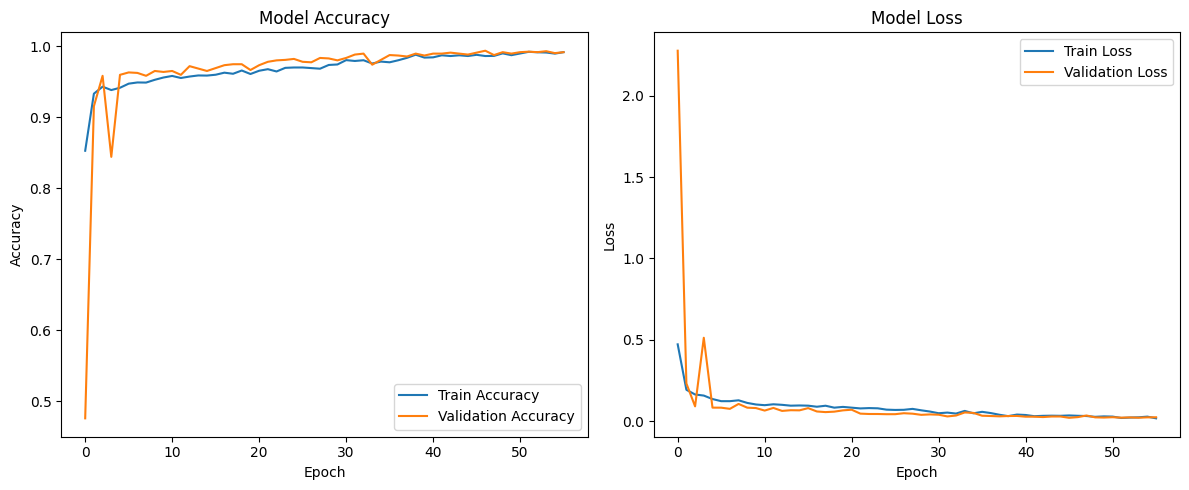

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq_onehot)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

y_pred_proba = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_seq_onehot, axis=1)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9317 - loss: 0.2232
Test accuracy: 0.9572
Test loss: 0.1460
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step



Evaluation Metrics:
Accuracy: 0.9572
Precision: 0.9602
Recall: 0.9572
F1 Score: 0.9568
Average Specificity: 0.9914

Class-wise Specificities:
Class 0 (WALKING): 1.0000
Class 1 (WALKING_UPSTAIRS): 0.9976
Class 2 (WALKING_DOWNSTAIRS): 0.9956
Class 3 (SITTING): 0.9935
Class 4 (STANDING): 0.9619
Class 5 (LAYING): 0.9996


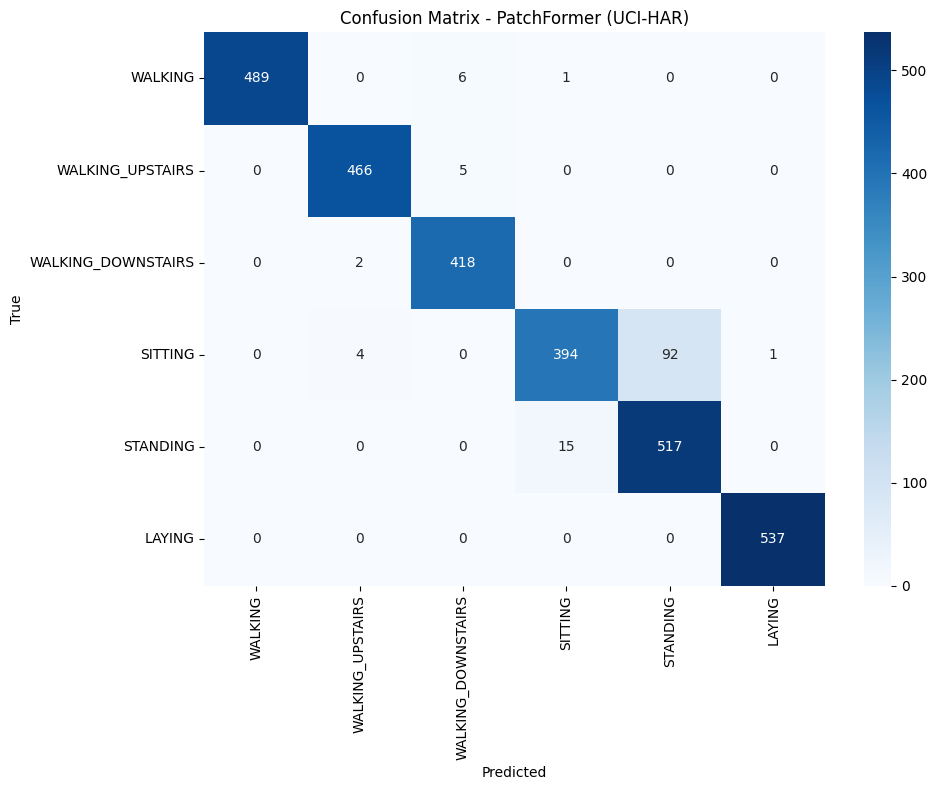

In [46]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks


# Assuming your activity labels are in a CSV file, load them
# Replace 'activity_labels.csv' with the actual file path
try:
    activity_labels = pd.read_csv('activity_labels.csv')
except FileNotFoundError:
    # If the file doesn't exist, create a DataFrame manually
    activity_labels = pd.DataFrame({
        'class_name': ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
        'label': [0, 1, 2, 3, 4, 5]  # Assuming labels are 0-indexed
    })

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate specificity for each class
def specificity_score(y_true, y_pred, num_classes=6):
    specificities = []

    for i in range(num_classes):
        true_negative = np.sum((y_true != i) & (y_pred != i))
        false_positive = np.sum((y_true != i) & (y_pred == i))

        if true_negative + false_positive == 0:
            specificities.append(1.0)
        else:
            specificities.append(true_negative / (true_negative + false_positive))

    return specificities

specificities = specificity_score(y_true, y_pred)
avg_specificity = np.mean(specificities)

print("\nEvaluation Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

print("\nClass-wise Specificities:")
for i, spec in enumerate(specificities):
    print(f"Class {i} ({activity_labels.iloc[i, 0]}): {spec:.4f}") # Assuming 'class_name' is in the first column (index 0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=activity_labels['class_name'].values,
           yticklabels=activity_labels['class_name'].values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PatchFormer (UCI-HAR)')
plt.tight_layout()
plt.show()

In [ ]:
# Version 2
'''
Input: (batch_size, time_steps, channels)
│
├── [Initial Projection]
│   ├── Conv1D (1x1, 64 filters) → BatchNorm → ReLU
│   └── Conv1D (1x1, 128 filters) → BatchNorm → ReLU
│
├── [Multi-Scale CNN Path] (병렬 분기)
│   ├── Conv1D (k=3, 42 filters) → BatchNorm
│   ├── Conv1D (k=7, 42 filters) → BatchNorm
│   └── Conv1D (k=11, 42 filters) → BatchNorm
│       ↓
│   Concatenate → Conv1D (1x1, 128) → BatchNorm → ReLU
│
├── [MST_Block] (Multi-Scale Temporal Aggregation)
│   ├── DepthwiseConv1D (k=3, 5, 7) 각각 적용
│   ├── 각 결과 → PointwiseConv1D (1x1)
│   ├── Concatenate → Conv1D (1x1, 128)
│
├── [Classification Head]
│   ├── GlobalAveragePooling1D
│   ├── Dense(128) → ReLU → Dropout(0.2)
│   ├── Dense(64) → ReLU
│   └── Dense(num_classes) → Softmax
│
Output: (batch_size, num_classes)
'''

In [56]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# 경량화된 PatchFormer 기반 모델

def build_lightweight_patchformer_model1(input_shape, num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Initial projection
    x = layers.Conv1D(64, kernel_size=1, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Multi-Scale CNN Path (3 kernel sizes only)
    kernel_sizes = [3, 7, 11]
    multi_scale_outputs = []
    for k in kernel_sizes:
        branch = layers.Conv1D(
            filters=128 // len(kernel_sizes),
            kernel_size=k,
            padding='same',
            activation='relu'
        )(x)
        branch = layers.BatchNormalization()(branch)
        multi_scale_outputs.append(branch)

    x = layers.Concatenate()(multi_scale_outputs)
    x = layers.Conv1D(128, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # (Optional) ABFA block (only one for simplicity)
    # x = ABFA(filters=128, activity_classes=num_classes)(x)

    # MST block (1 stage only)
    x = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(x)

    # Global Average Pooling + DNN Classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = build_lightweight_patchformer_model1(input_shape=(128, 9), num_classes=6)
model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq_onehot, test_size=0.2, random_state=42
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

history = model.fit(
    X_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 128, 64)   │        640 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_111[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 128, 128)  │      8,320 │ re_lu_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_112[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 128, 42)   │     16,170 │ re_lu_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_114 (Conv1D) │ (None, 128, 42)   │     37,674 │ re_lu_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_115 (Conv1D) │ (None, 128, 42)   │     59,178 │ re_lu_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_113[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_114[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_115[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_116 (Conv1D) │ (None, 128, 128)  │     16,256 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_116[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_12       │ (None, 128, 128)  │     35,328 │ re_lu_22[0][0]    │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ mst__block_12[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 200,508 (783.23 KB)

 Trainable params: 199,616 (779.75 KB)

 Non-trainable params: 892 (3.48 KB)

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.5295 - loss: 1.4365 - val_accuracy: 0.3270 - val_loss: 1.6767 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8266 - loss: 0.5173 - val_accuracy: 0.9028 - val_loss: 0.3609 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9292 - loss: 0.1966 - val_accuracy: 0.9558 - val_loss: 0.1185 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9457 - loss: 0.1437 - val_accuracy: 0.9565 - val_loss: 0.0979 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9501 - loss: 0.1315 - val_accuracy: 0.9585 - val_loss: 0.0911 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9522 - loss: 0.1182 - val_accuracy: 0.9585 - val_loss: 0.0904 - learning_rate: 1.0000e-04
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/ste

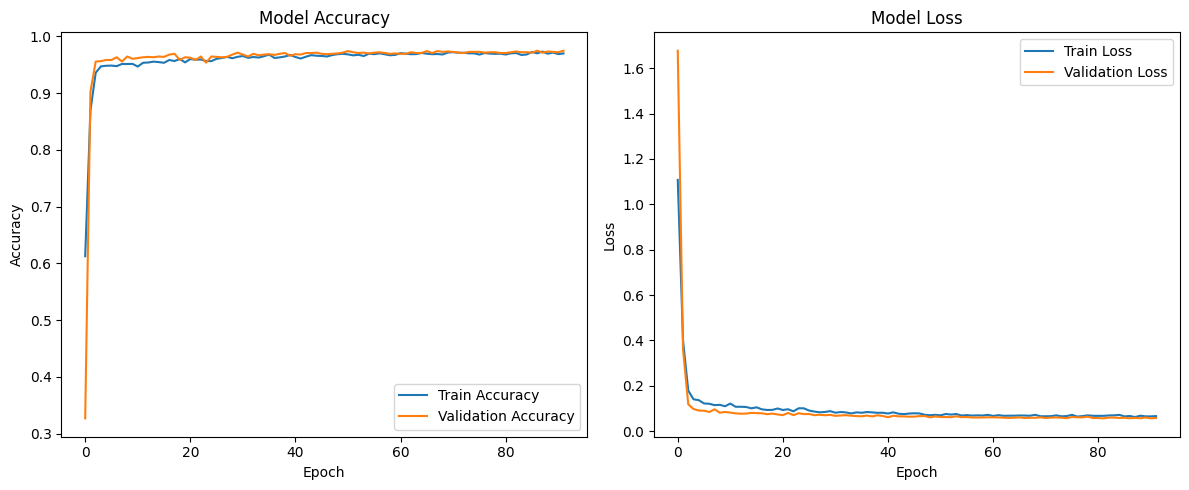

In [57]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Evaluation Metrics:
Accuracy: 0.9572
Precision: 0.9602
Recall: 0.9572
F1 Score: 0.9568
Average Specificity: 0.9914

Class-wise Specificities:
Class 0 (WALKING): 1.0000
Class 1 (WALKING_UPSTAIRS): 0.9976
Class 2 (WALKING_DOWNSTAIRS): 0.9956
Class 3 (SITTING): 0.9935
Class 4 (STANDING): 0.9619
Class 5 (LAYING): 0.9996


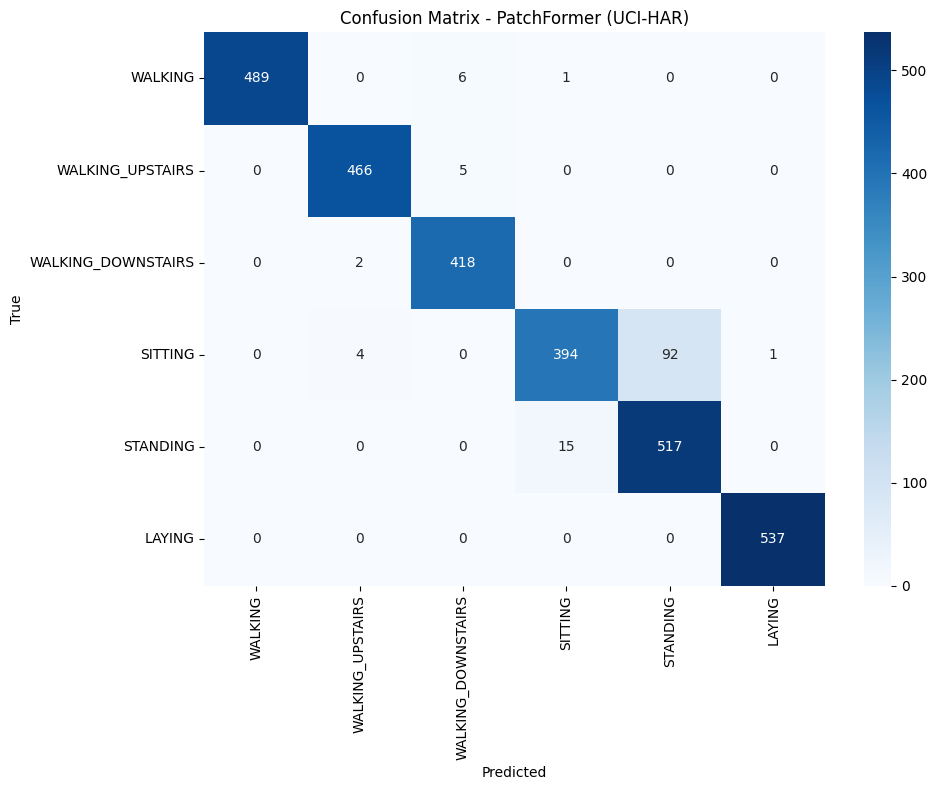

In [58]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks


# Assuming your activity labels are in a CSV file, load them
# Replace 'activity_labels.csv' with the actual file path
try:
    activity_labels = pd.read_csv('activity_labels.csv')
except FileNotFoundError:
    # If the file doesn't exist, create a DataFrame manually
    activity_labels = pd.DataFrame({
        'class_name': ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
        'label': [0, 1, 2, 3, 4, 5]  # Assuming labels are 0-indexed
    })

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate specificity for each class
def specificity_score(y_true, y_pred, num_classes=6):
    specificities = []

    for i in range(num_classes):
        true_negative = np.sum((y_true != i) & (y_pred != i))
        false_positive = np.sum((y_true != i) & (y_pred == i))

        if true_negative + false_positive == 0:
            specificities.append(1.0)
        else:
            specificities.append(true_negative / (true_negative + false_positive))

    return specificities

specificities = specificity_score(y_true, y_pred)
avg_specificity = np.mean(specificities)

print("\nEvaluation Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

print("\nClass-wise Specificities:")
for i, spec in enumerate(specificities):
    print(f"Class {i} ({activity_labels.iloc[i, 0]}): {spec:.4f}") # Assuming 'class_name' is in the first column (index 0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=activity_labels['class_name'].values,
           yticklabels=activity_labels['class_name'].values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PatchFormer (UCI-HAR)')
plt.tight_layout()
plt.show()

In [ ]:
'''# Version 3

Input: (batch_size, time_steps, channels)
│
├── [Initial Projection]
│   ├── Conv1D (1x1, 64 filters) → BatchNorm → ReLU
│   └── Conv1D (1x1, 128 filters) → BatchNorm → ReLU
│
├── [Multi-Scale CNN Path] (병렬 분기)
│   ├── Conv1D (k=3, 42 filters) → BatchNorm
│   ├── Conv1D (k=7, 42 filters) → BatchNorm
│   └── Conv1D (k=11, 42 filters) → BatchNorm
│       ↓
│   Concatenate → Conv1D (1x1, 128) → BatchNorm → ReLU
│
├── [ABFA Block] (Action-Based Feature Augmentation)
│   ├── 입력 → Dense(embedding projection)
│   ├── 행동 프로토타입과 유사도 계산 (dot-product)
│   ├── Attention → 클래스별 프로토타입 가중합
│   ├── Residual 연결 (입력 + 증강된 표현)
│   └── BN → Dropout → LayerNorm
│
├── [MST_Block] (Multi-Scale Temporal Aggregation)
│   ├── DepthwiseConv1D (k=3, 5, 7) 각각 적용
│   ├── 각 결과 → PointwiseConv1D (1x1)
│   ├── Concatenate → Conv1D (1x1, 128)
│
├── [Classification Head]
│   ├── GlobalAveragePooling1D
│   ├── Dense(128) → ReLU → Dropout(0.2)
│   ├── Dense(64) → ReLU
│   └── Dense(num_classes) → Softmax
│
Output: (batch_size, num_classes)

'''



In [59]:
import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------
# ABFA 모듈 정의
# -------------------------
class ABFA(tf.keras.layers.Layer):
    def __init__(self, filters, activity_classes=6, dropout_rate=0.2, **kwargs):
        super(ABFA, self).__init__(**kwargs)
        self.filters = filters
        self.activity_classes = activity_classes
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.action_prototypes = self.add_weight(
            name='action_prototypes',
            shape=(self.activity_classes, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.embedding_proj = layers.Dense(input_shape[-1])
        self.augment_proj = layers.Dense(input_shape[-1])
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(self.dropout_rate)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
        super().build(input_shape)

    def call(self, inputs):
        x_proj = self.embedding_proj(inputs)
        proto_similarity = tf.einsum('btd,cd->btc', x_proj, self.action_prototypes)
        proto_attention = tf.nn.softmax(proto_similarity, axis=-1)
        enhanced = tf.einsum('btc,cd->btd', proto_attention, self.action_prototypes)
        augmented = self.augment_proj(enhanced)
        x = self.bn(inputs + augmented)
        x = self.dropout(x)
        return self.layer_norm(x)

# -------------------------
# MST Block 정의 (예시 버전)
# -------------------------
class MST_Block(layers.Layer):
    def __init__(self, filters, kernel_sizes=(3, 5, 7), **kwargs):
        super(MST_Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes

        if len(kernel_sizes) == 3:
            self.filter_dims = [filters // 4, filters // 4, filters // 2]
        else:
            self.filter_dims = [filters // 2, filters // 2]

        self.conv_layers = []
        for i, k_size in enumerate(kernel_sizes):
            self.conv_layers.append(
                layers.DepthwiseConv1D(
                    kernel_size=k_size,
                    strides=1,
                    padding='same',
                    depth_multiplier=1
                )
            )
        self.proj_layers = [
            layers.Conv1D(self.filter_dims[i], kernel_size=1, padding='same') for i in range(len(kernel_sizes))
        ]
        self.output_proj = layers.Conv1D(filters, kernel_size=1)

    def call(self, inputs):
        outputs = []
        for conv, proj in zip(self.conv_layers, self.proj_layers):
            x = conv(inputs)
            x = proj(x)
            outputs.append(x)
        x = layers.Concatenate()(outputs)
        return self.output_proj(x)

# -------------------------
# 최종 모델 정의
# -------------------------
def build_lightweight_patchformer_model2(input_shape, num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Initial projection
    x = layers.Conv1D(64, kernel_size=1, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Multi-Scale CNN Path
    kernel_sizes = [3, 7, 11]
    multi_scale_outputs = []
    for k in kernel_sizes:
        branch = layers.Conv1D(
            filters=128 // len(kernel_sizes),
            kernel_size=k,
            padding='same',
            activation='relu'
        )(x)
        branch = layers.BatchNormalization()(branch)
        multi_scale_outputs.append(branch)

    x = layers.Concatenate()(multi_scale_outputs)
    x = layers.Conv1D(128, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ABFA block 추가
    x = ABFA(filters=128, activity_classes=num_classes)(x)

    # MST block
    x = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)

model = build_lightweight_patchformer_model2(input_shape=(window_size, X_train.shape[2]))
model.summary()

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_121 (Conv1D) │ (None, 128, 64)   │        640 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_121[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_122 (Conv1D) │ (None, 128, 128)  │      8,320 │ re_lu_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_122[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_123 (Conv1D) │ (None, 128, 42)   │     16,170 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_124 (Conv1D) │ (None, 128, 42)   │     37,674 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_125 (Conv1D) │ (None, 128, 42)   │     59,178 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_123[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_124[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_125[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_126 (Conv1D) │ (None, 128, 128)  │     16,256 │ concatenate_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_126[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_18 (ABFA)      │ (None, 128, 128)  │     34,560 │ re_lu_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_13       │ (None, 128, 128)  │     35,328 │ abfa_18[0][0]     │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ mst__block_13[0]

 Total params: 235,068 (918.23 KB)

 Trainable params: 233,920 (913.75 KB)

 Non-trainable params: 1,148 (4.48 KB)

In [60]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq_onehot, test_size=0.2, random_state=42
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

history = model.fit(
    X_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.5474 - loss: 1.4032 - val_accuracy: 0.2835 - val_loss: 2.1978 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8482 - loss: 0.4483 - val_accuracy: 0.8729 - val_loss: 0.3077 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9336 - loss: 0.1783 - val_accuracy: 0.9517 - val_loss: 0.1053 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9341 - loss: 0.1509 - val_accuracy: 0.9545 - val_loss: 0.0891 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9529 - loss: 0.1199 - val_accuracy: 0.9579 - val_loss: 0.0890 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9462 - loss: 0.1288 - val_accuracy: 0.9633 - val_loss: 0.0826 - learning_rate: 1.0000e-04
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/st

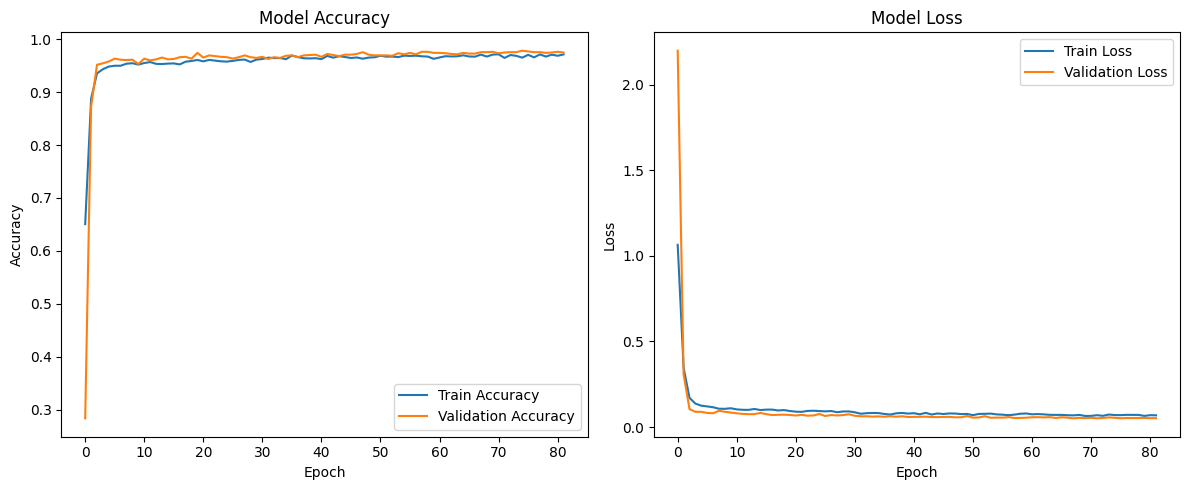

In [61]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Evaluation Metrics:
Accuracy: 0.9572
Precision: 0.9602
Recall: 0.9572
F1 Score: 0.9568
Average Specificity: 0.9914

Class-wise Specificities:
Class 0 (WALKING): 1.0000
Class 1 (WALKING_UPSTAIRS): 0.9976
Class 2 (WALKING_DOWNSTAIRS): 0.9956
Class 3 (SITTING): 0.9935
Class 4 (STANDING): 0.9619
Class 5 (LAYING): 0.9996


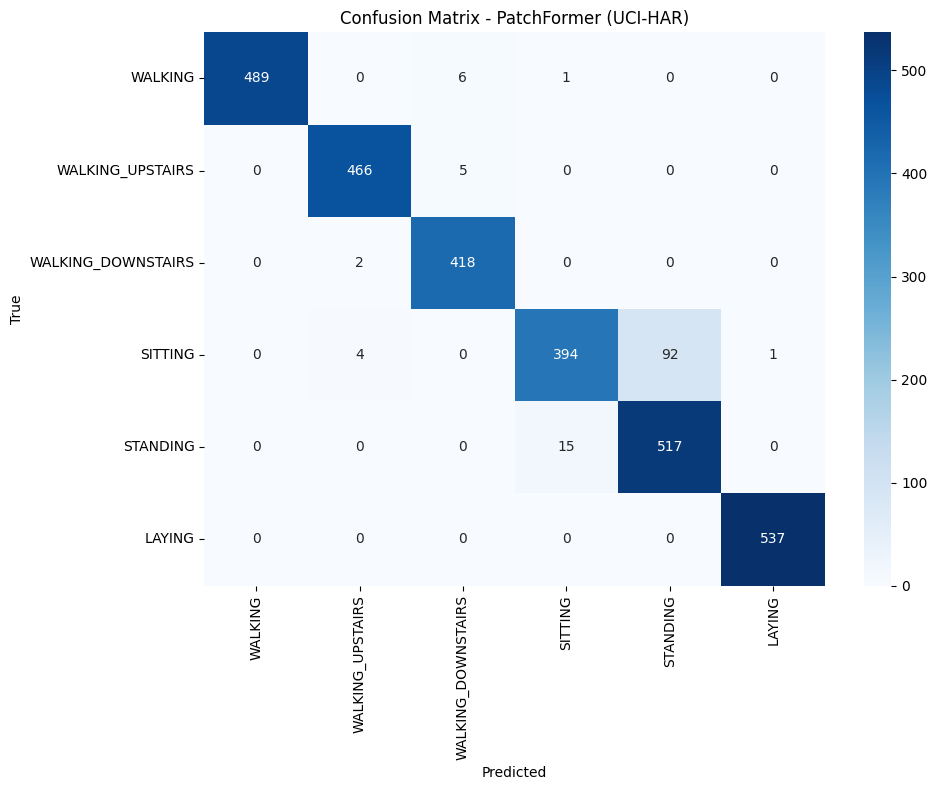

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks


# Assuming your activity labels are in a CSV file, load them
# Replace 'activity_labels.csv' with the actual file path
try:
    activity_labels = pd.read_csv('activity_labels.csv')
except FileNotFoundError:
    # If the file doesn't exist, create a DataFrame manually
    activity_labels = pd.DataFrame({
        'class_name': ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
        'label': [0, 1, 2, 3, 4, 5]  # Assuming labels are 0-indexed
    })

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate specificity for each class
def specificity_score(y_true, y_pred, num_classes=6):
    specificities = []

    for i in range(num_classes):
        true_negative = np.sum((y_true != i) & (y_pred != i))
        false_positive = np.sum((y_true != i) & (y_pred == i))

        if true_negative + false_positive == 0:
            specificities.append(1.0)
        else:
            specificities.append(true_negative / (true_negative + false_positive))

    return specificities

specificities = specificity_score(y_true, y_pred)
avg_specificity = np.mean(specificities)

print("\nEvaluation Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

print("\nClass-wise Specificities:")
for i, spec in enumerate(specificities):
    print(f"Class {i} ({activity_labels.iloc[i, 0]}): {spec:.4f}") # Assuming 'class_name' is in the first column (index 0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=activity_labels['class_name'].values,
           yticklabels=activity_labels['class_name'].values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PatchFormer (UCI-HAR)')
plt.tight_layout()
plt.show()

In [ ]:
# Version 4 ( + Transformer Encoder)



In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------
# ABFA 모듈 정의
# -------------------------
class ABFA(tf.keras.layers.Layer):
    def __init__(self, filters, activity_classes=6, dropout_rate=0.2, **kwargs):
        super(ABFA, self).__init__(**kwargs)
        self.filters = filters
        self.activity_classes = activity_classes
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.action_prototypes = self.add_weight(
            name='action_prototypes',
            shape=(self.activity_classes, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.embedding_proj = layers.Dense(input_shape[-1])
        self.augment_proj = layers.Dense(input_shape[-1])
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(self.dropout_rate)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
        super().build(input_shape)

    def call(self, inputs):
        x_proj = self.embedding_proj(inputs)
        proto_similarity = tf.einsum('btd,cd->btc', x_proj, self.action_prototypes)
        proto_attention = tf.nn.softmax(proto_similarity, axis=-1)
        enhanced = tf.einsum('btc,cd->btd', proto_attention, self.action_prototypes)
        augmented = self.augment_proj(enhanced)
        x = self.bn(inputs + augmented)
        x = self.dropout(x)
        return self.layer_norm(x)

# -------------------------
# MST Block 정의
# -------------------------
class MST_Block(layers.Layer):
    def __init__(self, filters, kernel_sizes=(3, 5, 7), **kwargs):
        super(MST_Block, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_sizes = kernel_sizes

        if len(kernel_sizes) == 3:
            self.filter_dims = [filters // 4, filters // 4, filters // 2]
        else:
            self.filter_dims = [filters // 2, filters // 2]

        self.conv_layers = []
        for i, k_size in enumerate(kernel_sizes):
            self.conv_layers.append(
                layers.DepthwiseConv1D(
                    kernel_size=k_size,
                    strides=1,
                    padding='same',
                    depth_multiplier=1
                )
            )
        self.proj_layers = [
            layers.Conv1D(self.filter_dims[i], kernel_size=1, padding='same') for i in range(len(kernel_sizes))
        ]
        self.output_proj = layers.Conv1D(filters, kernel_size=1)

    def call(self, inputs):
        outputs = []
        for conv, proj in zip(self.conv_layers, self.proj_layers):
            x = conv(inputs)
            x = proj(x)
            outputs.append(x)
        x = layers.Concatenate()(outputs)
        return self.output_proj(x)

# -------------------------
# 모델 정의
# -------------------------
def build_lightweight_patchformer_model3(input_shape, num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Initial projection
    x = layers.Conv1D(64, kernel_size=1, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(128, kernel_size=1, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Multi-Scale CNN Path
    kernel_sizes = [3, 7, 11]
    multi_scale_outputs = []
    for k in kernel_sizes:
        branch = layers.Conv1D(
            filters=128 // len(kernel_sizes),
            kernel_size=k,
            padding='same',
            activation='relu'
        )(x)
        branch = layers.BatchNormalization()(branch)
        multi_scale_outputs.append(branch)

    x = layers.Concatenate()(multi_scale_outputs)
    x = layers.Conv1D(128, kernel_size=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ABFA block
    x = ABFA(filters=128, activity_classes=num_classes)(x)

    # MST block
    x = MST_Block(filters=128, kernel_sizes=(3, 5, 7))(x)

    # Transformer Encoder block (1 layer)
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)
    ffn_output = layers.Dense(128, activation='relu')(x)
    ffn_output = layers.Dense(128)(ffn_output)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization()(x)

    # GlobalAveragePooling + Classifier
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)


model = build_lightweight_patchformer_model3(input_shape=(window_size, X_train.shape[2]))
model.summary()

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_131 (Conv1D) │ (None, 128, 64)   │        640 │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_131[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_132 (Conv1D) │ (None, 128, 128)  │      8,320 │ re_lu_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_132[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_133 (Conv1D) │ (None, 128, 42)   │     16,170 │ re_lu_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_134 (Conv1D) │ (None, 128, 42)   │     37,674 │ re_lu_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_135 (Conv1D) │ (None, 128, 42)   │     59,178 │ re_lu_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_133[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_134[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 42)   │        168 │ conv1d_135[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 128, 126)  │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_136 (Conv1D) │ (None, 128, 128)  │     16,256 │ concatenate_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_136[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ abfa_19 (ABFA)      │ (None, 128, 128)  │     34,560 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mst__block_14       │ (None, 128, 128)  │     35,328 │ abfa_19[0][0]     │
│ (MST_Block)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │    131,968 │ mst__block_14[0]

 Total params: 400,572 (1.53 MB)

 Trainable params: 399,424 (1.52 MB)

 Non-trainable params: 1,148 (4.48 KB)

In [64]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train_seq_onehot, test_size=0.2, random_state=42
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

history = model.fit(
    X_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.6967 - loss: 0.9389 - val_accuracy: 0.3086 - val_loss: 2.4614 - learning_rate: 1.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9351 - loss: 0.2035 - val_accuracy: 0.9062 - val_loss: 0.2143 - learning_rate: 1.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9390 - loss: 0.1526 - val_accuracy: 0.9517 - val_loss: 0.1138 - learning_rate: 1.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9397 - loss: 0.1522 - val_accuracy: 0.9538 - val_loss: 0.0972 - learning_rate: 1.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9405 - loss: 0.1386 - val_accuracy: 0.9558 - val_loss: 0.0957 - learning_rate: 1.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9514 - loss: 0.1189 - val_accuracy: 0.9558 - val_loss: 0.1026 - learning_rate: 1.0000e-04
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/st

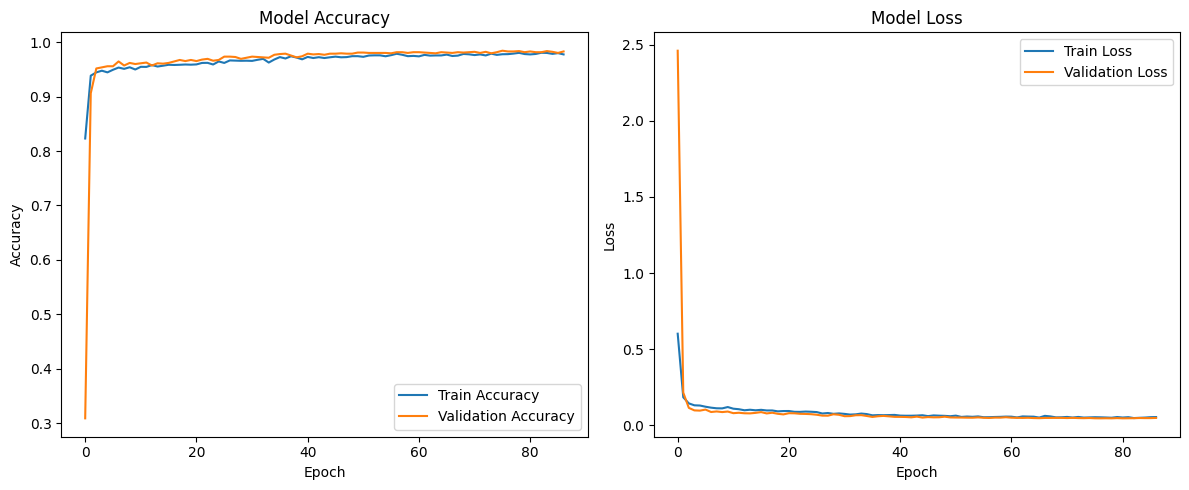

In [65]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Evaluation Metrics:
Accuracy: 0.9572
Precision: 0.9602
Recall: 0.9572
F1 Score: 0.9568
Average Specificity: 0.9914

Class-wise Specificities:
Class 0 (WALKING): 1.0000
Class 1 (WALKING_UPSTAIRS): 0.9976
Class 2 (WALKING_DOWNSTAIRS): 0.9956
Class 3 (SITTING): 0.9935
Class 4 (STANDING): 0.9619
Class 5 (LAYING): 0.9996


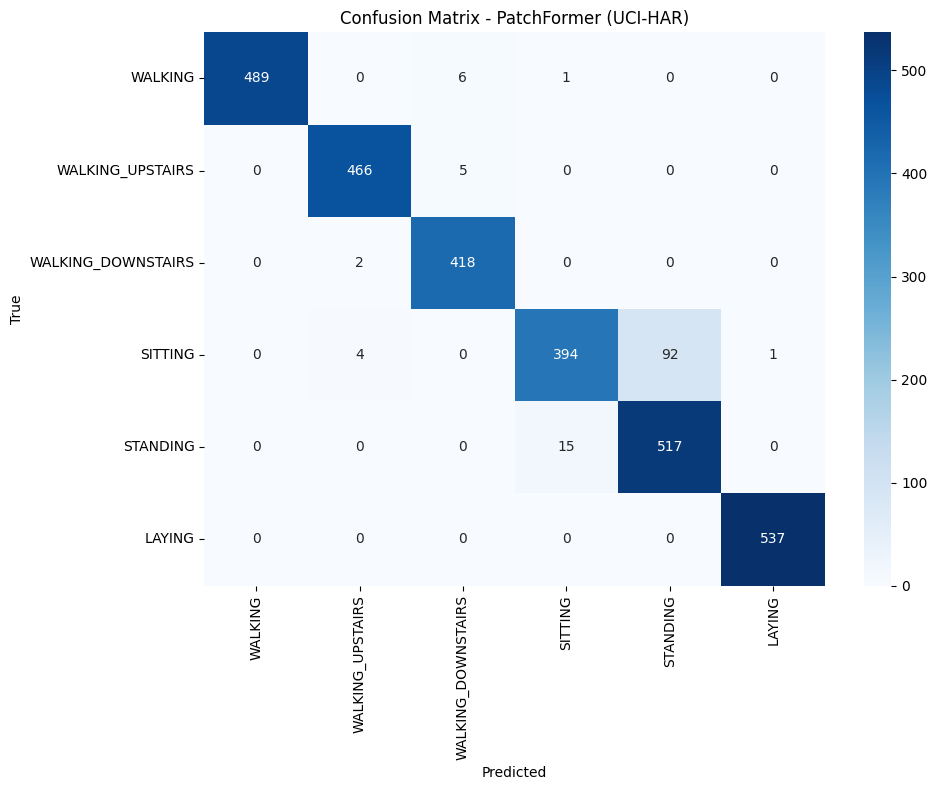

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks


# Assuming your activity labels are in a CSV file, load them
# Replace 'activity_labels.csv' with the actual file path
try:
    activity_labels = pd.read_csv('activity_labels.csv')
except FileNotFoundError:
    # If the file doesn't exist, create a DataFrame manually
    activity_labels = pd.DataFrame({
        'class_name': ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
        'label': [0, 1, 2, 3, 4, 5]  # Assuming labels are 0-indexed
    })

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate specificity for each class
def specificity_score(y_true, y_pred, num_classes=6):
    specificities = []

    for i in range(num_classes):
        true_negative = np.sum((y_true != i) & (y_pred != i))
        false_positive = np.sum((y_true != i) & (y_pred == i))

        if true_negative + false_positive == 0:
            specificities.append(1.0)
        else:
            specificities.append(true_negative / (true_negative + false_positive))

    return specificities

specificities = specificity_score(y_true, y_pred)
avg_specificity = np.mean(specificities)

print("\nEvaluation Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average Specificity: {avg_specificity:.4f}")

print("\nClass-wise Specificities:")
for i, spec in enumerate(specificities):
    print(f"Class {i} ({activity_labels.iloc[i, 0]}): {spec:.4f}") # Assuming 'class_name' is in the first column (index 0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=activity_labels['class_name'].values,
           yticklabels=activity_labels['class_name'].values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PatchFormer (UCI-HAR)')
plt.tight_layout()
plt.show()